In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

hour_result = pd.read_csv('../../model/output/check_hour.csv')
input_data = pd.read_csv('../../model/input/ricca_test_wind0.csv')

In [2]:
doy = hour_result['doy'].tolist()
hour = hour_result['hour'].tolist()
lai = hour_result['lai'].tolist()
PPFD = input_data['Irrad'].tolist()
PPFD = [x * 4.57 / 2 for x in PPFD]
timestamp = input_data['timestamp'].tolist()

In [3]:
##### Constants
KELVIN   = 273.15       # Kelvin temperature
R        = 8.314        # ideal gas constant
SBC      = 5.6697e-8    # Stefan-Boltzmann constant   W m-2 K-4
PSC      = 6.66e-4      # psychrometer constant
Cp       = 29.3         # specific heat of air    J mol-1 C-1
LAMBDA   = 44000.       # Latent heat of vaporization at 25 C J mol-1import numpy as np

### Constant or parameters
SC      = 1361.     # Solar conatant   W m-2
conv    = 4.57      # conversion from W m-2 to umol m-2 s-1
Po      = 101.3     # atomopheric pressure at sea level  kPa

### Parameters of Chinese cabbage
Nb      = 25         # residual leaf N content (about 0.5% N) mmol m-2  from de Pury(1997)
No      = 137        # leaf N content of canopy top         mmol m-2
Nl      = 120        # leaf N content per unit leaf area    mmol m-2
kn      = 0.713      # coefficient for leaf N allocation
# Vcmax = 110        # rubisco capacity by calculation      umol m-2 s-1 from de Pury(1997)
# Xn = Vcmax/(Nl-Nb) # ratio of rubisco capacity to leaf N

### clumping factor
clump   = 0.5

In [4]:
a       = 0.72    # atmospheric transmission coefficients of PAR
fa      = 0.426   # forward scattering coeff of PAR
rhocd   = 0.036   # canopy reflection coeff for diffuse PAR
rhoh    = 0.04    # reflection coeff of a canopy with horizontal leaves
rhol    = 0.10    # reflection coeff for PAR
taul    = 0.05    # leaf transmissivity to PAR
sigma   = 0.15    # leaf scattering coeff for PAR (rhol + taul)
kd      = 0.78 * clump   # diffuse PAR extinction coeff.             0.5 <- clumping
kdprime = 0.719   # diffuse & scattered diffuse OAR ext coeff

lat = np.radians(37.0)
P = 100.0

sunlit, shaded param

In [5]:
decl = []
ha = []
sin_a = []
cos_b = []
incl = []
sunhgt = []
kb = []
kbprime = []
rhocb = []
m = []
fd = []

for i in range(len(doy)):
    decl.append(-0.4093 * np.cos(2 * np.pi * (doy[i] + 10) / 365))  # sun declination   rad
    ha.append(np.pi / 12 * (hour[i] - 12))                          # hour angle   rad
    sin_a.append(np.sin(decl[i])*np.sin(lat))
    cos_b.append(np.cos(decl[i])*np.cos(lat))
    incl.append(np.arccos(sin_a[i] + cos_b[i] * np.cos(ha[i])))     # sun inclination   rad
    sunhgt.append(max(0.05, np.pi / 2 - incl[i]))                   # solar height   rad
    kb.append(0.5/np.sin(sunhgt[i]) * clump)                        # beam radiation extinction coeff  0.5 <- clumping
    kbprime.append(0.46/np.sin(sunhgt[i]))                          # beam + scattered beam PAR ext coeff
    rhocb.append(1-np.exp(-2*rhoh*kb[i]/(1+kb[i])))                 # canopy reflec coeff for beam PAR
    m.append(P / Po /np.sin(sunhgt[i]))                             # optical air mass
    fd.append((1-a**m[i])/(1+a**m[i] * (1/fa-1)) )

Icsun, Icshade

In [6]:
It = PPFD
Id = []
Ib = []
Icbs = []
Icd = []
Icdb = []
Icdf = []
Icsc = []
Icshdf = []

Icsun = []
Icshsc = []


for i in range(len(PPFD)):
    Id.append(It[i] * fd[i])                       # diffuse fraction of irradiance PAR umol m-2 s-1
    Ib.append(It[i] - Id[i])                       # beam fraction of irradiance PAR umol m-2 s-1

    ## for total leaves
    Icbs.append(Ib[i]*(1-rhocb[i])*(1-np.exp(-kbprime[i]*lai[i])))       # canopy absorbed beam irrad.
    Icd.append(Id[i]*(1-rhocd)*(1-np.exp(-kdprime*lai[i])))        # canopy absorbed diffuse irrad.

    ## for sunlit leaves
    Icdb.append(Ib[i]*(1-sigma)*(1-np.exp(-kb[i]*lai[i])))       # absorbed direct beam by sunlit leaves
    Icdf.append(Id[i]*(1-rhocd)*(1-np.exp(-(kdprime+kb[i])*lai[i])) * \
        kdprime/(kdprime+kb[i]))                                # absorbed diffse beam by sunlit leaves
    Icsc.append(Ib[i]*((1-rhocb[i])*(1-np.exp(-(kbprime[i]+kb[i])*lai[i]))*kbprime[i]/(kbprime[i]+kb[i])- \
        (1-sigma)*(1-np.exp(-2*kb[i]*lai[i]))/2))             # absorbed scattered beam by sunlit leaves
    Icsun.append(Icdb[i] + Icdf[i] + Icsc[i])

    ## for shaded leaves
    Icshdf.append(Id[i]*(1-rhocd)*(1-np.exp(-kdprime*lai[i])-(1-np.exp(-(kdprime+kb[i])*lai[i]))* \
    kdprime/(kdprime+kb[i])))                              # absorbed diffuse beam by shaded leaves

    Icshsc.append(Ib[i]*((1-rhocb[i])*(1-np.exp(-kbprime[i]*lai[i])-(1-np.exp(-(kbprime[i]+kb[i])*lai[i]))* \
    kbprime[i]/(kbprime[i]+kb[i]))-(1-sigma)*(1-np.exp(-kb[i]*lai[i])-(1-np.exp(-2*kb[i]*lai[i]))/2)))

In [7]:
laiSun = []
laiSh = []

for i in range(len(lai)):
    laiSun.append((1 - np.exp(-kb[i] * lai[i])) / kb[i])
    laiSh.append(lai[i] - laiSun[i])

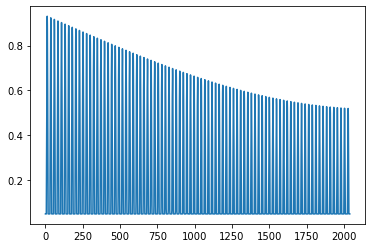

In [8]:
plt.plot(sunhgt);

In [9]:

result = {'timestamp':[],'hour':[],'lai':[],'PPFD':[],'decl':[], 'ha':[], 'sin_a':[], 'cos_b':[], 'incl':[], 'sunhgt':[], 'kb':[], 'kbprime':[], 'rhocb':[], 'm':[], 'fd':[],
          'It':[], 'Id':[], 'Ib':[], 'Icbs':[], 'Icd':[], 'Icdb':[], 'Icdf':[], 'Icsc':[], 'Icshdf':[], 'Icsun':[], 'Icshsc':[],
          'laiSun':[], 'laiSh':[]}

In [10]:

for i in range(len(timestamp)):
    result['timestamp'].append(timestamp[i])
    result['hour'].append(hour[i])
    result['lai'].append(lai[i])
    result['PPFD'].append(PPFD[i])
    result['decl'].append(decl[i])
    result['ha'].append(ha[i])
    result['sin_a'].append(sin_a[i])
    result['cos_b'].append(cos_b[i])
    result['incl'].append(incl[i])
    result['sunhgt'].append(sunhgt[i])
    result['kb'].append(kb[i])
    result['kbprime'].append(kbprime[i])
    result['rhocb'].append(rhocb[i])
    result['m'].append(m[i])
    result['fd'].append(fd[i])
    result['It'].append(It[i])
    result['Id'].append(Id[i])
    result['Ib'].append(Ib[i])
    result['Icbs'].append(Icbs[i])
    result['Icd'].append(Icd[i])
    result['Icdb'].append(Icdb[i])
    result['Icdf'].append(Icdf[i])
    result['Icsc'].append(Icsc[i])
    result['Icshdf'].append(Icshdf[i])
    result['Icsun'].append(Icsun[i])
    result['Icshsc'].append(Icshsc[i])
    result['laiSun'].append(laiSun[i])
    result['laiSh'].append(laiSh[i])

In [11]:
fraction_param = pd.DataFrame(result).set_index('timestamp')
fraction_param.to_csv('fraction_param.csv')
fraction_param

,hour,lai,PPFD,decl,ha,sin_a,cos_b,incl,sunhgt,kb,...,Icbs,Icd,Icdb,Icdf,Icsc,Icshdf,Icsun,Icshsc,laiSun,laiSh
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-09-20 0:00,0,0.002522,0.0000,0.005284,-3.141593,0.003180,0.798624,2.490537,0.05,5.002084,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.002506,0.000016
2017-09-20 1:00,1,0.002522,0.2285,0.005284,-2.879793,0.003180,0.798624,2.446871,0.05,5.002084,...,0.000017,0.000398,0.000009,0.000395,0.000009,0.000002,0.000413,5.497591e-08,0.002506,0.000016
2017-09-20 2:00,2,0.002522,0.2285,0.005284,-2.617994,0.003180,0.798624,2.330145,0.05,5.002084,...,0.000017,0.000398,0.000009,0.000395,0.000009,0.000002,0.000413,5.497591e-08,0.002506,0.000016
2017-09-20 3:00,3,0.002522,0.2285,0.005284,-2.356194,0.003180,0.798624,2.167033,0.05,5.002084,...,0.000017,0.000398,0.000009,0.000395,0.000009,0.000002,0.000413,5.497591e-08,0.002506,0.000016
2017-09-20 4:00,4,0.002522,0.2285,0.005284,-2.094395,0.003180,0.798624,1.978097,0.05,5.002084,...,0.000017,0.000398,0.000009,0.000395,0.000009,0.000002,0.000413,5.497591e-08,0.002506,0.000016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-13 19:00,19,3.895113,0.2285,-0.405425,1.832596,-0.237361,0.733894,2.012309,0.05,5.002084,...,0.000762,0.206150,0.000692,0.027584,0.000147,0.178565,0.028424,-7.782663e-05,0.199917,3.695197
2017-12-13 20:00,20,3.895113,0.2285,-0.405425,2.094395,-0.237361,0.733894,2.219694,0.05,5.002084,...,0.000762,0.206150,0.000692,0.027584,0.000147,0.178565,0.028424,-7.782663e-05,0.199917,3.695197
2017-12-13 21:00,21,3.895113,0.2285,-0.405425,2.356194,-0.237361,0.733894,2.428440,0.05,5.002084,...,0.000762,0.206150,0.000692,0.027584,0.000147,0.178565,0.028424,-7.782663e-05,0.199917,3.695197
